## Data preprocessing

To run SANGO, the first step is to create an AnnData object from the raw data.

The h5ad file should contain cells as obs and peaks as var. Within the 'var' category, at least three columns - 'chr', 'start', and 'end' - are required to denote the genomic region of each peak.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import pandas as pd
import numpy as np

### load data

In [2]:
adata = sc.read_h5ad("data/LargeIntestineA_LargeIntestineB.h5ad")
print(np.unique(adata.obs["Batch"]))

['LargeIntestineA' 'LargeIntestineB']


### filtering and saving data

In [3]:
def make_anndata(adata, chrom, start, end, path):
    adata.var['chr'] = chrom
    adata.var['start'] = start
    adata.var['end'] = end

    # basic stats
    sc.pp.filter_cells(adata, min_genes=0)
    sc.pp.filter_genes(adata, min_cells=0)

    # a peak need to be accessible in 1% cells
    thres = int(adata.shape[0]*0.01)
    adata = adata[:, adata.var['n_cells']>thres]

    chrs = ['chr'+str(i) for i in range(1,23)] + ['chrX', 'chrY']
    adata = adata[:, adata.var['chr'].isin(chrs)]
    
    print(adata)
    adata.write(path)
    return adata

In [4]:
adata_reference = adata[adata.obs["Batch"] == "LargeIntestineB"]
adata_query = adata[adata.obs["Batch"] == "LargeIntestineA"]

concat_adata = sc.AnnData.concatenate(adata_reference, adata_query)
print(concat_adata)

concat_adata = make_anndata(
    concat_adata,
    concat_adata.var["chrom"],
    concat_adata.var["chromStart"],
    concat_adata.var["chromEnd"],
    "preprocessed_data/LargeIntestineB_LargeIntestineA.h5ad",
)

AnnData object with n_obs × n_vars = 7086 × 114756
    obs: 'cell', 'tissue', 'tissue.replicate', 'cluster', 'subset_cluster', 'tsne_1', 'tsne_2', 'subset_tsne1', 'subset_tsne2', 'id', 'cell_label', 'Batch', 'CellType', 'batch', 'n_genes'
    var: 'chrom', 'chromStart', 'chromEnd', 'chr', 'start', 'end', 'n_cells'
View of AnnData object with n_obs × n_vars = 7086 × 114756
    obs: 'cell', 'tissue', 'tissue.replicate', 'cluster', 'subset_cluster', 'tsne_1', 'tsne_2', 'subset_tsne1', 'subset_tsne2', 'id', 'cell_label', 'Batch', 'CellType', 'batch', 'n_genes'
    var: 'chrom', 'chromStart', 'chromEnd', 'chr', 'start', 'end', 'n_cells'


## Run CACNN

In [5]:
%cd SANGO/CACNN

/data/user/luomai/SANGO/SANGO/CACNN


In [6]:
!python main.py -i ../../preprocessed_data/LargeIntestineB_LargeIntestineA.h5ad \
                -g mm9 \
                -o ../../output/LargeIntestineB_LargeIntestineA

## Run GraphTransFormer

In [7]:
%cd ../GraphTransformer

/data/user/luomai/SANGO/SANGO/GraphTransformer


In [8]:
!python main.py --data_dir ../../output/LargeIntestineB_LargeIntestineA/CACNN_output.h5ad \
                --train_name_list LargeIntestineB --test_name LargeIntestineA \
                --save_path ../../output \
                --save_name LargeIntestineB_LargeIntestineA

Namespace(K=10, M=30, batch_size=50000, cpu=False, data_dir='../../output/LargeIntestineB_LargeIntestineA/CACNN_output.h5ad', device=4, dropout=0.0, edge_ratio=0.0, epochs=300, eval_step=1, hidden_channels=64, lamda=1.0, lr=0.001, metric='acc', num_heads=4, num_layers=3, rb_order=2, rb_trans='sigmoid', runs=1, sample_ratio=0.1, save_name='LargeIntestineB_LargeIntestineA', save_path='../../output', seed=42, tau=0.25, test_name=['LargeIntestineA'], train_name_list=['LargeIntestineB'], train_prop=0.5, use_act=False, use_bn=True, use_gumbel=True, use_jk=False, use_residual=True, valid_prop=0.25, weight_decay=0.005)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical)

## Visualization

### Umap

In [9]:
%cd ../../

/data/user/luomai/SANGO


<Figure size 7680x5760 with 0 Axes>

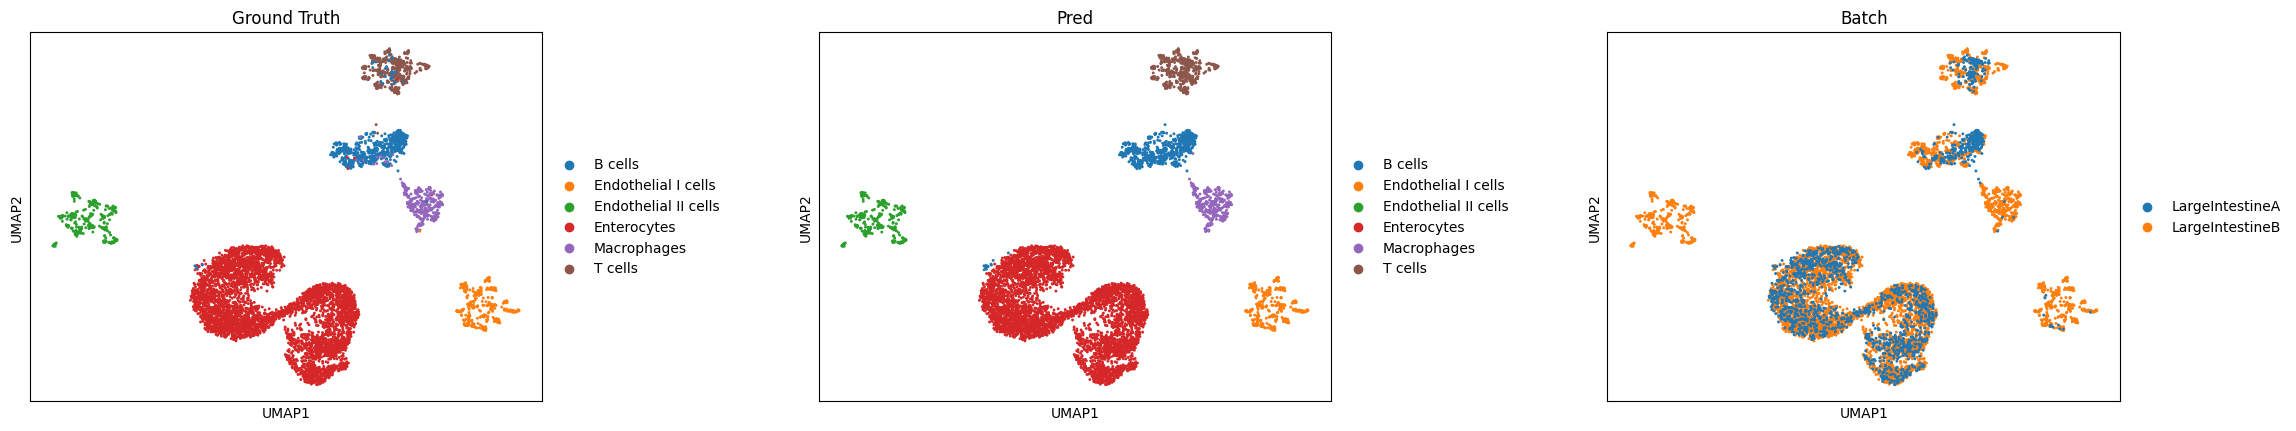

In [10]:
import matplotlib.pyplot as plt

adata = sc.read_h5ad("output/LargeIntestineB_LargeIntestineA/embedding.h5ad")

fontsize = 10
plt.figure(dpi=1200)
sc.pp.neighbors(adata, n_neighbors=25, use_rep='X', n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["CellType", "Pred", "Batch"], title=["Ground Truth", "Pred", "Batch"],
            legend_fontsize=fontsize,
            wspace=0.4)

<Figure size 7680x5760 with 0 Axes>

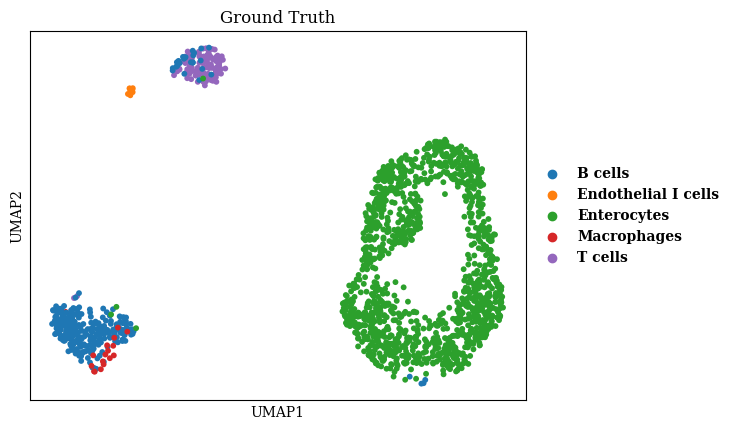

In [16]:
adata = sc.read_h5ad("output/LargeIntestineB_LargeIntestineA/embedding.h5ad")
adata = adata[adata.obs["Batch"] == "LargeIntestineA"]
fontsize = 10
plt.figure(dpi=1200)
sc.pp.neighbors(adata, n_neighbors=25, use_rep='X', n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["CellType"], title=["Ground Truth"],
            legend_fontsize=fontsize,
            wspace=0.4)

<Figure size 7680x5760 with 0 Axes>

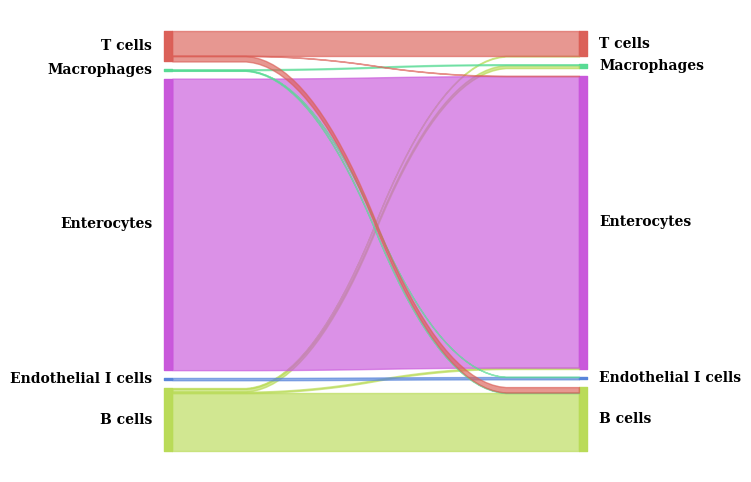

In [17]:
from pySankey.sankey import sankey

pred_col = 'Pred'
true_col = 'CellType'

plt.rcParams['font.weight'] = "heavy"
plt.figure(dpi=1200)
sankey(
    adata.obs[pred_col], adata.obs[true_col], aspect=10,
    fontsize=10, leftLabels = list(np.unique(adata.obs[pred_col])), rightLabels = list(np.unique(adata.obs[true_col]))
    )